In [1]:
import numpy as np, os, glob, matplotlib.pyplot as plt, pandas as pd, colorcet, matplotlib as mpl
from tqdm import tqdm_notebook as tqdm
import miniball
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.measure import label
import shapely.ops, shapely.geometry as geom

In [2]:
COLORS_CLUSTERS = {
 'walk': '#0072b2',
 'one-leg-after-other': '#eee8c7',
 'extrude-slow': '#f0e442',
 'extrude': '#009e73',
 'left-leg': '#e69f00',
 'both-legs': '#ccc8a7',
 'stationary': '#000000',
 'stationary-posterior': '#666666',
 'stationary-anterior': '#666666',
 'stabilimentum': '#cc79a7',
 'noisy': None,
 'right-leg': '#56b4e9',
 'bend-abdomen': '#d55e00'
}

In [3]:
fnameP = 'Z:/behavior/*/wavelet/rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.clusters.npy'
fnameA = 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.clusters.npy'

fnamesP = [x for x in glob.glob(fnameP) if 'RIG' not in x]
fnamesA = [os.path.join(os.path.dirname(x), fnameA) for x in fnamesP]
len(fnamesP)

21

In [4]:
arrClustersP = [np.load(x)[:,0] for x in fnamesP]
arrClustersA = [np.load(x)[:,0] for x in fnamesA]

In [5]:
arrUsetsP = [np.all(~np.isnan(np.load(x.replace('.clusters.npy', '.npy'))), axis=1) for x in fnamesP]
arrUsetsA = [np.all(~np.isnan(np.load(x.replace('.clusters.npy', '.npy'))), axis=1) for x in fnamesA]

In [6]:
arrTsneP = [np.load(x.replace('.clusters.npy', '.filtered2.npy'))[:, 2:4] for x in fnamesP]
arrTsneA = [np.load(x.replace('.clusters.npy', '.filtered2.npy'))[:, 2:4] for x in fnamesA]

In [7]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

ANTERIOR = 1
POSTERIOR = 0

fnameClusterLabelsA = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\cluster_names.txt'
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'
clusterLabelsAmanual = loadLabels(fnameClusterLabelsA)
clusterLabelsPmanual = loadLabels(fnameClusterLabelsP)
del clusterLabelsAmanual['noisy']
del clusterLabelsPmanual['noisy']

In [8]:
fnameSharedTsneP = '\\\\?\\Y:\\wavelet\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.smoothed.watershed.npy'
fnameSharedTsneA = '\\\\?\\Y:\\wavelet\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.smoothed.watershed.npy'
arrSharedTsneP = np.load(fnameSharedTsneP)[:, :, 0, 1].astype(int)
arrSharedTsneA = np.load(fnameSharedTsneA)[:, :, 0, 1].astype(int)

In [96]:
# Load densities
Hs = []
for arr in arrTsneA:
    arr = arr[~np.any(np.isnan(arr), axis=1)]
    H, _, _ = np.histogram2d(arr[:,0], arr[:,1], bins=(200,200), range=((0, 1), (0, 1)))
    H = np.clip(H, 0, np.percentile(H, 99))
    Hs.append(H)
densityA = np.mean(Hs, axis=0)

Hs = []
for arr in arrTsneP:
    arr = arr[~np.any(np.isnan(arr), axis=1)]
    H, _, _ = np.histogram2d(arr[:,0], arr[:,1], bins=(200,200), range=((0, 1), (0, 1)))
    H = np.clip(H, 0, np.percentile(H, 99))
    Hs.append(H)
densityP = np.mean(Hs, axis=0)

In [10]:
def isEmbeddingStable(x):
    a = [[],]
    for i, c in enumerate(x):
        if len(a[-1]) == 0 or c == a[-1][-1]:
            a[-1] = a[-1] + [c,]
        else:
            a.append([c,])
    a = [np.full(len(x), len(x)>=12, dtype=np.bool) for x in a]
    return np.hstack(a)

arrStableA = [isEmbeddingStable(x) for x in tqdm(arrClustersA, leave=False)]
arrStableP = [isEmbeddingStable(x) for x in tqdm(arrClustersP, leave=False)]

In [11]:
arrClustersAstable = []
for x, st in zip(arrClustersA, arrStableA):
    x2 = x.copy()
    x2[~st] = -1
    arrClustersAstable.append(x2)
    
arrClustersPstable = []
for x, st in zip(arrClustersP, arrStableP):
    x2 = x.copy()
    x2[~st] = -1
    arrClustersPstable.append(x2)

### Plot chains

In [234]:
fnameIdx = 10
idxAnchor = np.argwhere(np.isin(arrClustersAstable[fnameIdx], clusterLabelsAmanual['bend-abdomen']))[5582, 0]
idxWalk = np.argwhere(np.isin(arrClustersAstable[fnameIdx], clusterLabelsAmanual['walk']))[3300, 0]
#idxWalk = np.argwhere(np.isin(arrClustersAstable[fnameIdx], clusterLabelsAmanual['walk']))[4980, 0]
#idxWalk = np.argwhere(np.isin(arrClustersAstable[fnameIdx], clusterLabelsAmanual['walk']))[2400, 0]
#idxWalk = np.argwhere(np.isin(arrClustersAstable[fnameIdx], clusterLabelsAmanual['walk']))[8000, 0]
idxAnchor, idxWalk

(317856, 131154)

In [133]:
import skimage.draw, matplotlib.patches as patches

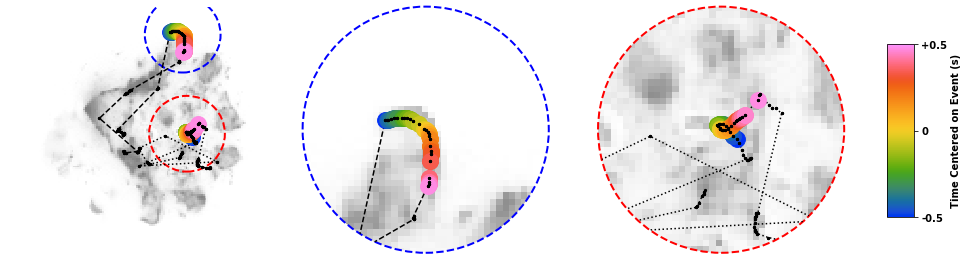

In [235]:
s = -25
e = 25

cm = plt.get_cmap('cet_CET_R1')
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

for _idxBeh, (i, ls, cc) in enumerate([(idxAnchor, '--', 'blue'), (idxWalk, ':', 'red')]):
    for iplot, ax in enumerate([axs[0], axs[1]] if _idxBeh==0 else [axs[0], axs[2]]):
        ax.set_axis_off()
        img = np.flip(densityA, axis=0).copy()
        cy, cx = np.nanmean(arrTsneA[fnameIdx][(i-1):(i+2), :], axis=0)
        _im = ax.imshow(img, vmax=np.max(densityA) * 2, extent=(0, 1, 0, 1), cmap='gray_r')
        _pl = []
        for _s, _e in [(-75, s), (s, e), (e, 75)]:
            _pl.append(ax.plot(
                arrTsneA[fnameIdx][(i+_s):(i+_e+1), 1],
                arrTsneA[fnameIdx][(i+_s):(i+_e+1), 0], color='black', linestyle=ls))

            for f in range(_s, _e):
                t = (f-_s)/(_e-_s)
                if _s < 0 < _e:
                    ax.scatter(
                        arrTsneA[fnameIdx][i+f, 1],
                        arrTsneA[fnameIdx][i+f, 0], 
                        color=cm(t), s=250, zorder=10)
                ax.scatter(
                    arrTsneA[fnameIdx][i+f, 1],
                    arrTsneA[fnameIdx][i+f, 0], 
                    color='black', s=5, zorder=12)

        if iplot == 0:
            ax.set_xlim(0.1, 0.75)
            ax.set_ylim(0.2, 0.85)

            circle1 = plt.Circle((cx, cy), 0.1, color=cc, linewidth=2, fill=False, linestyle='--')
            ax.add_patch(circle1)

        if iplot == 1:
            circ = patches.Circle((cx, cy), 0.1, transform=ax.transData)
            _im.set_clip_path(circ)
            for pl in _pl:
                pl[0].set_clip_path(circ)
            for coll in ax.collections:
                coll.set_clip_path(circ)

            circle1 = plt.Circle((cx, cy), 0.1, color=cc,  
                                 linewidth=2, fill=False, linestyle='--', clip_on=False)
            ax.add_patch(circle1)
            
            ax.set_xlim(cx-0.1, cx+0.1)
            ax.set_ylim(cy-0.1, cy+0.1)

# Legend
cbar_ax = fig.add_axes([0.94, 0.3, 0.025, 0.4])
mpl.colorbar.ColorbarBase(cbar_ax, cmap=cm, orientation = 'vertical', ticks=[0, 0.5, 1])
cbar_ax.set_yticklabels(['-0.5', '0', '+0.5'])
cbar_ax.set_ylabel('Time Centered on Event (s)')

fig.savefig('C:/Users/acorver/Desktop/paper-figures/tsne-chain-example-anchoring-v2.pdf', bbox_inches='tight')